<b>Breast Cancer Wisconsin (Diagnostic) Data Set</b> 
(reference to UCI Machine Learning Repository <a href="http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29">description</a>)

In [1]:
# coding: utf-8
import multiprocessing 
multiprocessing.set_start_method('spawn')

Using multiprocessing code, and running in Python 3, a work around is necessary for process forking by adding mp.set_start_method('spawn') to scripts. One also needs to make sure there are no CUDA calls prior to starting your subprocesses; torch.cuda.is_available() and torch.manual_seed both count as a CUDA calls in PyTorch 0.2.0. Such calls would initialize the CUDA layer causing subprocesses to hang if they try to re-initialize.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

from IPython.display import display
import pickle

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

from collections import Counter

import seaborn as sns
sns.set()

from tqdm import tqdm_notebook, tqdm

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve

import torch
from torch import nn

from lib.utils import *

from lib.classifier import Classifier, torch_weight_init, Stopping, OutlierSampler, exp_decay, to_var, PytorchLogger

from lib.model import MLP

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 85%


In [3]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "GPU"                 : True ,
    "SEED"                : 0
})

In [4]:
# if not HP.SEED:
#     torch.cuda.is_available = lambda : False

# Seed random generators for repro 
np.random.seed(HP.SEED)  
# torch.manual_seed(HP.SEED);
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(HP.SEED)

In [5]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
feature_names = dataset.feature_names
target_names = dataset.target_names
data = pd.DataFrame(np.c_[dataset['target'], dataset['data']], columns= np.append(['diagnosis'], feature_names ))

X = np.float32(data.drop('diagnosis', axis=1).values)
y = np.int64(data['diagnosis'].values)   # conversion to int64 for pytorch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       30
number of classes:        2
data type:                float32
number of train samples:  381 (pos=236, neg=145, size=0MB)
number of test samples:   188 (pos=121, neg=67, size=0MB)
labels                    ['malignant' 'benign']


In [6]:
params = {
    'module'                       : MLP,
    'module_H'                     : 15,
    'module_D_in'                  : X_train.shape[1] ,
    'module_D_out'                 : 2 ,
    'module_dropout'               : 0.5,

    'module_initialize'            : torch_weight_init ,

    'max_epochs'                   : 1000,
    'batch_size'                   : 80 ,
    'batch_shuffle'                : True,
    'validation_ratio'             : 0.33,
    'validation_shuffle'           : True,

    'optimizer'                    : torch.optim.SGD ,
    'optimizer_lr'                 : 0.1 ,
    'optimizer_momentum'           : 0.9 ,
    'optimizer_weight_decay'       : 5e-4 ,
    'optimizer_nesterov'           : True ,

    'criterion'                    : nn.CrossEntropyLoss ,
    'criterion_size_average'       : True ,

    'scheduler'                    : torch.optim.lr_scheduler.LambdaLR ,
    'scheduler_lr_lambda'          : exp_decay,

    'stopping'                     : Stopping ,
    'stopping_patience'            : 100 ,

    'scoring'                      : metrics.f1_score ,

#     'progress_bar'                 : tqdm,

    'random_state'                 : 10
}

pipeline = Pipeline(steps=[
                ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    SMOTE(random_state=HP.SEED)),
                ('classifier', Classifier(**params))
                ])

y_pred = pipeline.fit(X_train, y_train).predict(X_test)
y_prob = pipeline.predict_proba(X_test)

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))              # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))   

Confusion Matrix
 [[ 64   3]
 [  1 120]]
Accuracy  0.9787234042553191
Recall    0.9917355371900827
Precision 0.975609756097561
F1        0.9836065573770492
ROC AUC   0.9734797088935488


In [7]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='accuracy', verbose=0, n_jobs=-1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.9576023391812866 0.031688406786295524


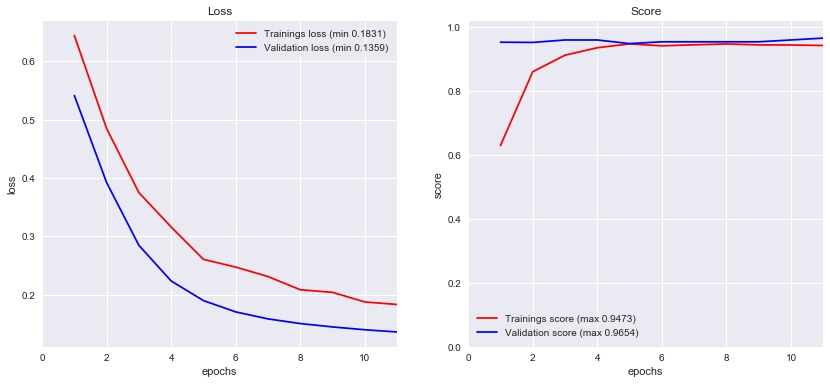

In [8]:
# Plot the curves for loss and scores to check for overfitting
clf = pipeline.named_steps['classifier']
plot_loss_curve(clf.loss_train_, clf.score_train_,  clf.loss_valid_, clf.score_valid_)

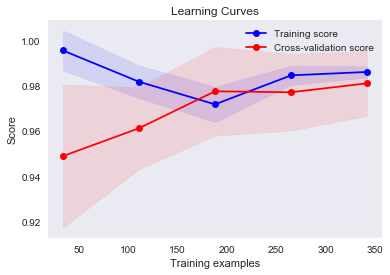

In [9]:
# https://www.ritchieng.com/machinelearning-learning-curve/ to interprete this curve
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
_ = plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, cv=cv, shuffle=True, 
                    n_jobs=4, random_state=HP.SEED)

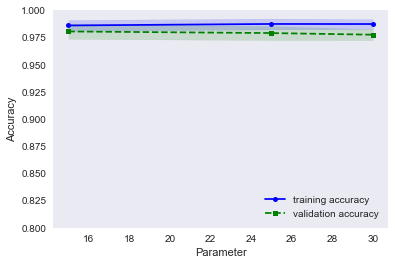

In [10]:
# Finetuning of hyperparameters using sklearn validation_curve 
# - uncomment the parameter to validate below and define a value range to evaluate
# - result is a plot accuracy over parameter that visualizes the dependency

# param_name ='classifier__optimizer_lr'
# param_range = [  0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 1.1, 2.0]

param_name ='classifier__module_H'
param_range = [  15, 25, 30]

# param_name ='classifier__stopping_patience'
# param_range = [ 120, 150, 240]

# param_name ='classifier__batch_size'
# param_range = [ 70, 80, 90]

cv = KFold(n_splits=3, shuffle=True, random_state=HP.SEED).split(X)
train_scores, test_scores = validation_curve(
                 estimator=pipeline,
                 X=X,
                 y=y,
                 param_name=param_name,
                 param_range=param_range,
                 scoring = 'f1',
                 cv=cv, n_jobs=4)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
          color='blue', marker='o',
          markersize=5,
          label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')
plt.plot(param_range, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='validation accuracy')
plt.fill_between(param_range,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

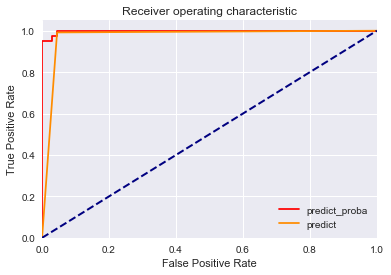

In [11]:
plot_roc_curve(y_test, y_pred, y_prob)

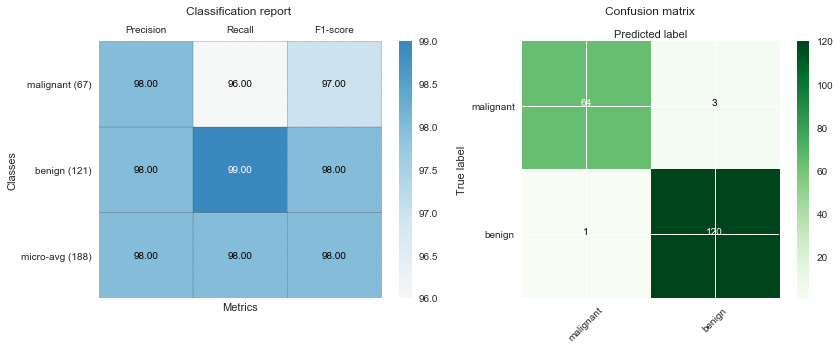

In [12]:
plot_classifier_summary(y_test, y_pred, target_names)

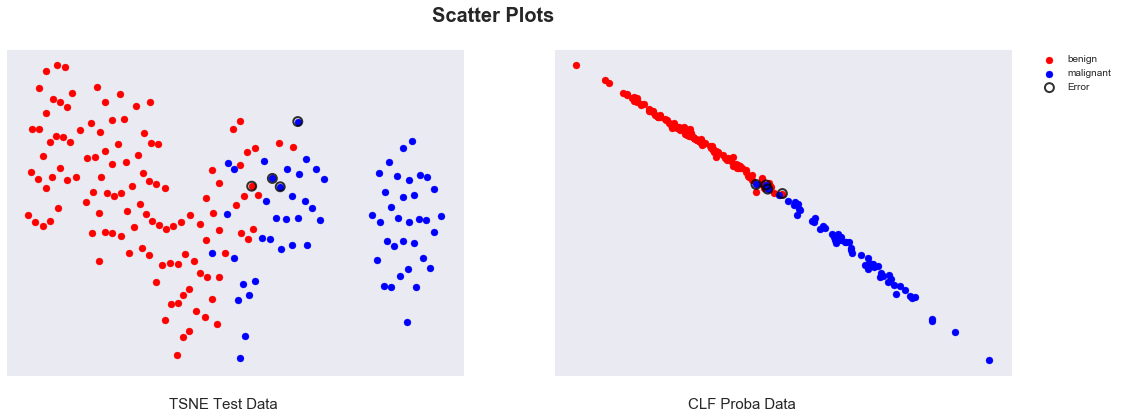

In [13]:
plot_scatter_plots(X_test, y_pred, y_prob, y_test, target_names, figsize=(18,6))

In [14]:
classifier_summary_report(X, y, pipeline.predict(X), target_names)

Note: weighted average f1-score 
              precision    recall  f1-score   support

  malignant       0.99      0.96      0.97       212
     benign       0.98      0.99      0.98       357

avg / total       0.98      0.98      0.98       569



'Data points=569'

'Features=30'

'Class dist.=0.627417'

'F1 valid=0.984701'

'ACC=0.980668'

'ROC_AUC=0.976930'

'LOG_LOSS=0.667720'

'Misclassified=11'

'Data points=[40, 73, 81, 91, 135, 213, 263, 297, 413, 514, 541]'

In [15]:
print_model_summary(pipeline.named_steps['classifier'].module_)

Summary for model: MLP
_________________________________________________________________
Layer (type)                 Shape                     Param #   
fc1.0 (Linear)               ((15, 30),)               450       
_________________________________________________________________
fc1.1 (BatchNorm1d)          ((15,), (15,))            30        
_________________________________________________________________
fc1.2 (ReLU)                 ()                        0         
_________________________________________________________________
fc2.0 (Linear)               ((15, 30),)               450       
_________________________________________________________________
fc2.1 (BatchNorm1d)          ((15,), (15,))            30        
_________________________________________________________________
fc2.2 (ReLU)                 ()                        0         
_________________________________________________________________
classifier.0 (Dropout)       ()                      

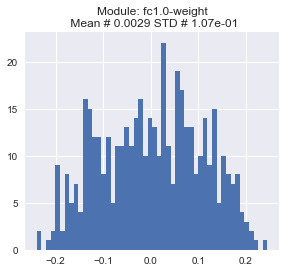

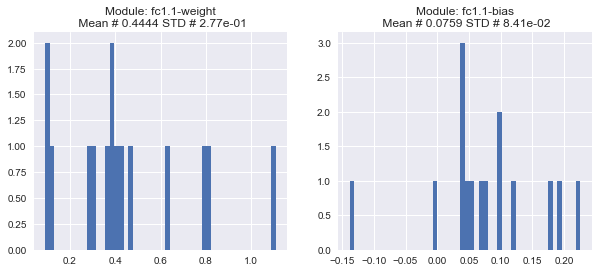

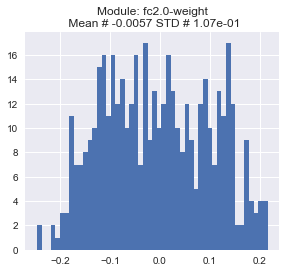

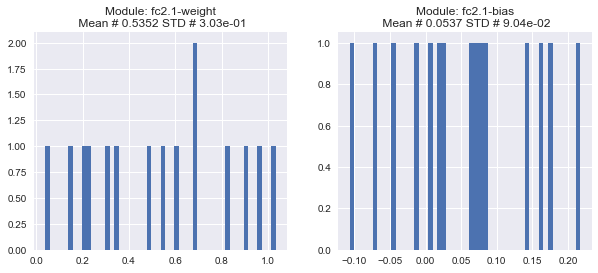

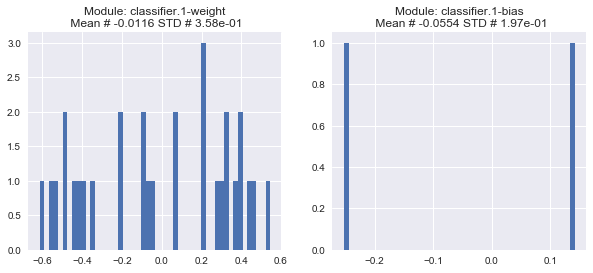

In [16]:
plot_layer_stats(pipeline.named_steps['classifier'].module_)

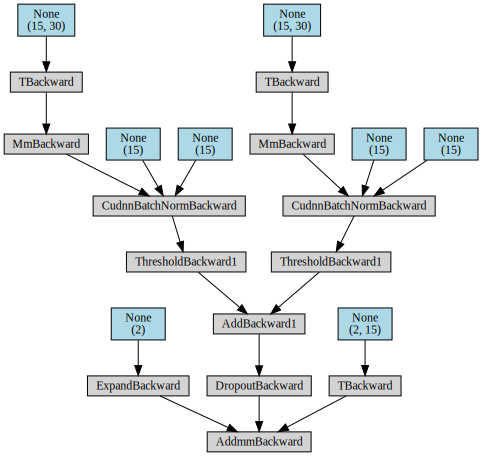

In [17]:
plot_model_graph(pipeline.named_steps['classifier'].module_(to_var(torch.from_numpy(X_test).float())), 
                 pipeline.named_steps['classifier'].module_.state_dict())